In [8]:
using Plots
using Makie
using GraphMakie.NetworkLayout
using CairoMakie
using Tenet
using TensorOperations
using LinearAlgebra
using Graphs
using GraphPlot
using EinExprs
using Combinatorics
using LaTeXStrings
using FileIO
using JLD2
Makie.inline!(true)
include("julia_functions.jl")



generate_random_quantum_circuit (generic function with 1 method)

In [9]:
# TN = generate_random_quantum_circuit(6, 5, 1)
# graph, tv_map, ie_map, weighted_edge_list, ei_map = extract_graph_representation(TN, false) # Extract the graphs.jl structure from the Tenet.TensorNetwork
# export_to_alphazero = [TN, graph, tv_map, ie_map, weighted_edge_list, ei_map]
# FileIO.save("transport variables/export_to_alphazero.jld2","A2", export_to_alphazero)


Definition of the relevant transformation functions in the notebook below:

Transform the full tensornetwork to the tree structure by sequentially applying the transformation defined in taken path

But first - redefinition of all the relevant functions

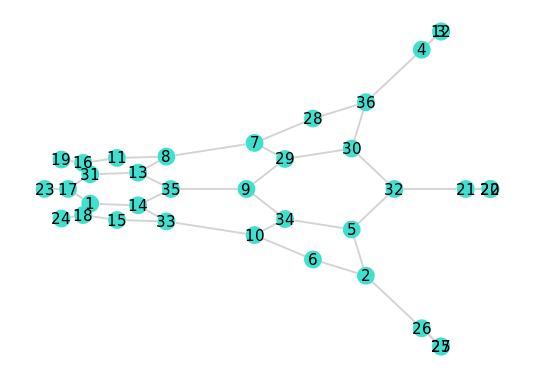

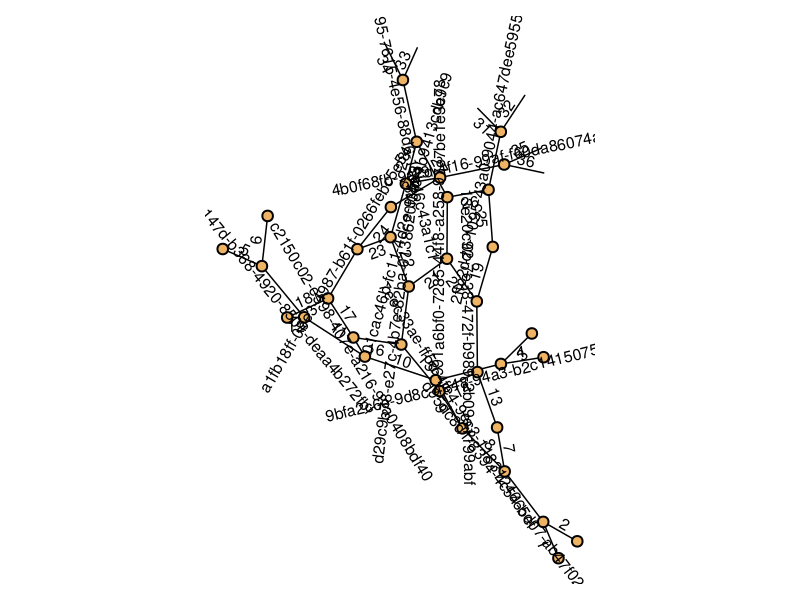

TensorNetwork(#tensors=36, #inds=49)
[([29, 9, 34, 5, 32, 30], (5, 32)), ([14, 33, 15, 18, 1], (1, 14)), ([10, 6, 2, 5, 34], (10, 34)), ([8, 11, 16, 31, 13], (8, 13)), ([17, 31, 13, 35, 14, 33, 15, 18, 1], (1, 18)), ([28, 36, 30, 29, 7], (7, 28)), ([34, 5, 2, 6, 10, 33, 14, 35, 9], (14, 35)), ([13, 35, 9, 29, 7, 8, 11, 16, 31], (16, 31))]


tree_i_fication (generic function with 1 method)

In [36]:
TN, graph, tv_map, ie_map, weighted_edge_list, ei_map = FileIO.load("transport variables/export_to_alphazero.jld2","A2")
taken_path = FileIO.load("transport variables/taken_path.jld2","taken_path")


display(gplot(graph, nodelabel=[i for i in 1:nv(graph)], layout=spectral_layout))
println(TN)
println(taken_path)
display(Makie.plot(TN, labels=true))




function replace_index(tensor, replace_inds, new_inds)
    
    mapping = Dict(zip(replace_inds, new_inds))
    #display(mapping)
    current_inds = inds(tensor)
    ids = []
    for id in current_inds
        if id in replace_inds
            push!(ids, mapping[id])
        else
            push!(ids, id)
        end
    end
    new_tensor = Tenet.Tensor(tensor.data, [ids...])
    return new_tensor
end


function extract_partial_tn_loop(TN, index_cycle, printing = false)
    println("index_cycle = ", index_cycle)

    tensors_in_loop = collect(Set([tensor for id in index_cycle for tensor in Tenet.select(TN, Symbol(id))])) #correct orderding of variable definitions

    current_tn = TensorNetwork(tensor for tensor in tensors_in_loop)
    if printing == true
        drawing1 = Makie.plot(current_tn, node_color=[:darkred for i in 1:length(tensors(current_tn))], labels=true, layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end
        
    return current_tn
end



function generate_unique_symbols()

    """
    Function which generates a list of new symbols for index replacing capability
    """
    new_symbols = [Symbol(i) for i in 1000:1500]
   
    return new_symbols
  
end


function create_index_isomorphismgroup(size_index1, size_index2, indices)
    n = size_index1*size_index2
    identity_data = Matrix{Int64}(I, n, n)
    tensor_isomorphism = reshape(identity_data, (size_index1, size_index2, n))
    identity_isomorphism = Tenet.Tensor(tensor_isomorphism, [(indices...)])
    return identity_isomorphism
end


function create_index_isomorphismsplit(propagation_size, cut_size, new_indices, propagation_index)
    size_id_to_tensor = convert(Int64, propagation_size/cut_size)
    size_loop_part = cut_size
    n = propagation_size
    identity_data = Matrix{Int64}(I, n, n)
    tensor_isomorphism = reshape(identity_data, (propagation_size, size_id_to_tensor, size_loop_part))
    identity_isomorphism = Tenet.Tensor(tensor_isomorphism, [propagation_index, new_indices...])
    return identity_isomorphism
end

function collect_tensors_along_loop(loop_tn, index_cycle, index_to_cut)

    """
    Funtion whcih sequentially walks along the loop and selects the relevant tensors
    """
    global start_tensor
    global end_tensor
    connectedtensors = Tenet.select(loop_tn, index_to_cut)
    firstsymbol = index_cycle[1]
    for tensor in connectedtensors
        if !isempty(intersect(inds(tensor), [firstsymbol]))
            global start_tensor = tensor
        else
            global end_tensor = tensor
        end
    end
    tensors_ordered_loop = []
    for i in 1:length(tensors(loop_tn))
        if i == length(tensors(loop_tn))
            push!(tensors_ordered_loop, end_tensor)
            return tensors_ordered_loop
        end
        if i == 1
            push!(tensors_ordered_loop, start_tensor)
            continue
        end
        connecting_id = intersect(inds(tensors_ordered_loop[i-1]), [Symbol(id) for id in index_cycle])
        next_tensor = [tensorc for tensorc in Tenet.select(loop_tn, connecting_id)  if tensorc != tensors_ordered_loop[i-1]][1]
        index_cycle = filter(x -> x != connecting_id[1], index_cycle)
        push!(tensors_ordered_loop, next_tensor)
    end

    return tensors_ordered_loop
end

function transform_to_MPS(TN, edge_to_cut, node_cycle, printing=false)

    """
    Function which takes in full tensor network, a cycle of tensor nodes
    and an edge to cut (tuple of two nodes).
    Returns the MPS like structured loop tensor network 
    defined by the node cycle.
    """
    
    # graph edge to tensor network edge
    index_to_cut = ei_map[edge_to_cut]

    ### node cycle to index cycle
    tensors = [tv_map[node] for node in node_cycle]
    index_cycle = []

    for (i, tensor) in enumerate(tensors)
        if i < length(tensors)
            connection = intersect(inds(tensor), inds(tensors[i+1]))[1]
            push!(index_cycle, connection)
        end
        if i == length(tensors)
            connection = intersect(inds(tensor), inds(tensors[1]))[1]
            push!(index_cycle, connection)
        end
        index_cycle = [id for id in index_cycle]

    end

    loop_tn = extract_partial_tn_loop(TN, index_cycle, false)
    old_loop = deepcopy(loop_tn)
    index_cycle_to_remove = deepcopy(index_cycle)

    """
    Take care of the case where no dangling edges are found: 
    Create a compatible loop TN
    """

    Tens = Tenet.tensors(loop_tn)
    additional_fake_indices_of_size1 = [Symbol("f1"), Symbol("f2"), Symbol("f3"), Symbol("f4"), Symbol("f5"),  
                                        Symbol("f6"),  Symbol("f7"), Symbol("f8"), Symbol("f9"), Symbol("f10"),
                                        Symbol("f11"), Symbol("f12"), Symbol("f13"), Symbol("f14")]
    t_compat = []
    used_fakes = []
    z = 1
    for t in Tens
        if length(inds(t)) == 2
            new_t = Tenet.Tensor(reshape(t.data, (size(t.data)[1], size(t.data)[2], 1)), (inds(t)..., additional_fake_indices_of_size1[z]))
            push!(used_fakes, additional_fake_indices_of_size1[z])
            z += 1
            push!(t_compat, new_t)
            continue
        end
        push!(t_compat, t)
    end

    loop_tn = Tenet.TensorNetwork(t_compat)
    
    # Generate an adequate amount of new indices for the transformation
    new_inds = generate_unique_symbols()

    """
    collect tensors along the loop from start_tensor to end_tensor
    and reorganize_cycle for correct ordering along the loop
    """

    for (idx, index) in enumerate(index_cycle)
        if index == index_to_cut[1]
            index_cycle = vcat(index_cycle[idx+1:end], index_cycle[1:idx-1])
            break
        end
    end


    ordered_along_loop = collect_tensors_along_loop(loop_tn, deepcopy(index_cycle), index_to_cut)

    new_tn_tensors = []
    global contract_list = []
    global propagating_size
    global cut_size
    global propagating_index
    global dangling_list = []
  
    id_cycle_old = deepcopy(index_cycle)

    # Modify the index cycle for this code to work properly
    pushfirst!(index_cycle, index_to_cut[1])

    """
    Walk along the loop and make the necessary alterations at each step
    """

    for (i, tensor) in enumerate(ordered_along_loop)

        # cases on the edges of the tensor network loop are treated seperately
        if i == 1

            """
            First tensor
            """

            cut_size = [size(tensor, id) for id in inds(tensor) if id == index_to_cut[1]][1]
            new_virtual_inds = deepcopy(new_inds[1:3])
            current_inds = inds(tensor)
            dangling_leg = setdiff(inds(tensor), [Symbol(id) for id in index_cycle])
            push!(dangling_list, deepcopy(dangling_leg))
            replace_leg = intersect(inds(tensor), [Symbol(id) for id in index_cycle])
            iso = create_index_isomorphismgroup(size(tensor, replace_leg[1]), size(tensor, replace_leg[2]), new_virtual_inds)
            new_tensor = replace_index(tensor, replace_leg, new_virtual_inds[1:2])
            contract_list = vcat(contract_list, new_virtual_inds[1:2])
            push!(new_tn_tensors, new_tensor)

            if printing == true
                println("Created a group:")
                println("indices tensor $(i)", inds(new_tensor), "with sizes", [size(new_tensor, id) for id in inds(new_tensor)])
                println("indices identity_1:", inds(iso), "with sizes", [size(iso, id) for id in inds(iso)])
            end

            push!(new_tn_tensors, iso)
            propagating_index = inds(iso)[end]
            propagating_size = size(iso, propagating_index)
            continue
        end

        if i == length(ordered_along_loop)

        """
        Final tensor
        """
       
            new_virtual_inds = new_inds[4+(i-2)*4:4+(i-1)*4-1]
            current_inds = inds(tensor)
            dangling_leg = setdiff(inds(tensor), [Symbol(id) for id in index_cycle])
            push!(dangling_list, deepcopy(dangling_leg))
            replace_leg = intersect(inds(tensor), [Symbol(id) for id in index_cycle])
            iso_inv = create_index_isomorphismsplit(propagating_size, cut_size, [new_virtual_inds[2], new_virtual_inds[1]], propagating_index)
            #println("replacement legs:", replace_leg)
            replace_leg_order = [id for id in replace_leg]
            leg1_id = findfirst(x -> x == replace_leg_order[1], index_cycle)
            leg2_id = findfirst(x -> x == replace_leg_order[2], index_cycle)
            #possible reshuffling
            if leg2_id < leg1_id
                replace_leg = [replace_leg[2], replace_leg[1]]                  # get the right orderding of tensor indices
            end
            #println("replacement legs:", replace_leg)
            new_tensor = replace_index(tensor, replace_leg, [new_virtual_inds[1], new_virtual_inds[2]])   
            if printing == true
                println("Created a split:")

                println("indices identity  $(i-1) inv", inds(iso_inv), "with sizes", [size(iso_inv, id) for id in inds(iso_inv)])
                println("indices tensor $(i)", inds(new_tensor), "with sizes", [size(new_tensor, id) for id in inds(new_tensor)])
            end
            contract_list = vcat(contract_list, new_virtual_inds[1:2])
            push!(new_tn_tensors, new_tensor)
            push!(new_tn_tensors, iso_inv)
            break
        end

        """
         General "bulk" case
        """

        # grab new indices
        new_virtual_inds = new_inds[4+(i-2)*4:4+(i-1)*4-1]
        iso_inv = create_index_isomorphismsplit(propagating_size, cut_size, [new_virtual_inds[1], new_virtual_inds[2]], propagating_index)
        current_inds = inds(tensor)
        dangling_leg = setdiff(inds(tensor), [Symbol(id) for id in index_cycle])
        push!(dangling_list, deepcopy(dangling_leg))

        replace_leg = intersect(inds(tensor),[Symbol(id) for id in index_cycle])
        replace_leg_order = [id for id in replace_leg]
        leg1_id = findfirst(x -> x == replace_leg_order[1], index_cycle)
        leg2_id = findfirst(x -> x == replace_leg_order[2], index_cycle)
        #possible reshuffling
        if leg2_id < leg1_id
            replace_leg = [replace_leg[2], replace_leg[1]]                      # get the right orderding of tensor indices
        end
        new_tensor = replace_index(tensor, replace_leg, [new_virtual_inds[1], new_virtual_inds[3]])
        iso = create_index_isomorphismgroup(cut_size, size(new_tensor, new_virtual_inds[3]), [new_virtual_inds[2], new_virtual_inds[3], new_virtual_inds[4]])
        propagating_index = inds(iso)[end]
        propagating_size = size(iso, propagating_index)

        if printing == true
            println("Created a split:")

            println("indices identity  $(i-1) inv", inds(iso_inv), "with sizes", [size(iso_inv, id) for id in inds(iso_inv)])
            println("indices tensor $(i)", inds(new_tensor), "with sizes", [size(new_tensor, id) for id in inds(new_tensor)])
            println("Created a group:")

            println("indices identity $(i)", inds(iso), "with sizes", [size(iso, id) for id in inds(iso)])
        end

        contract_list = vcat(contract_list, new_virtual_inds[1:3])

        push!(new_tn_tensors, iso_inv)
        push!(new_tn_tensors, new_tensor)
        push!(new_tn_tensors, iso)
    end
    mps_network = Tenet.TensorNetwork(new_tn_tensors)
    
    # contract the internal indices to get the desired MPS structure
    for id in contract_list
        #contracting two tensors contracts fully along all shared indices
        # --> not everything in the list will be in the tensornetwork
        if id ∈ inds(mps_network)
            contraction_step(mps_network, [id])
        end
    end

    #determine the connection indices
    connection_indices = []
    for i in 1:length(dangling_list)-1
        t1 = Tenet.select(mps_network, dangling_list[i])[1]
        t2 = Tenet.select(mps_network, dangling_list[i+1])[1]
        c_idx = intersect(inds(t1),inds(t2))[1]
        push!(connection_indices, c_idx)
    end

    # remove the fake indices
    for fake_index in used_fakes
        #println("used fake = ", fake_index)
        t_old = Tenet.select(mps_network, fake_index)[1]
        # case where it is an edge tensor
        if length(inds(t_old)) == 2
            id_keep = setdiff(inds(t_old), [fake_index])[1]
            t_new = Tenet.Tensor(reshape(t_old.data, size(t_old, id_keep)), [id_keep])
            pop!(mps_network, t_old)
            push!(mps_network, t_new)
        end
        # case where it is a bulk tensor
        if length(inds(t_old)) == 3
            id_keep = setdiff(inds(t_old), [fake_index])
            t_new = Tenet.Tensor(reshape(t_old.data, (size(t_old, id_keep[1]), size(t_old, id_keep[2]))), (id_keep))
            pop!(mps_network, t_old)
            push!(mps_network, t_new)
        end

    end
    
    ### current index connection path -> replace with old index connection path
    # TODO: use something else than the dangling_list

    fidelity = loop_and_exact_mps_overlap(old_loop, mps_network)

    #replace the connection indices
    for i in 1:length(connection_indices)
        replace!(mps_network, connection_indices[i] => id_cycle_old[i])
    end

    return old_loop, mps_network, index_cycle_to_remove, fidelity
end

function loop_and_exact_mps_overlap(loop, mps)
    #println("Loop_indices = ", [id for t in tensors(loop) for id in inds(t) ])
    l_net = deepcopy(loop)
    norm_l = abs(norm(Tenet.contract(l_net)[1]))
    mps_net = deepcopy(mps)
    norm_mps = abs(norm(Tenet.contract(mps_net)[1]))

    for t in tensors(mps_net)
        push!(l_net, t)
    end
    drawing1 = Makie.plot(l_net, node_color=[:darkred for i in 1:length(tensors(l_net))], layout=Stress(), edge_color=:grey80)
    display(drawing1)
    overlap = abs2(Tenet.contract(l_net)[1])
    println("overlap = ", overlap, "\n loop norm = ", norm_l, "\n  mps_norm = ", norm_mps)
    F = overlap
    return F/(norm_l*norm_mps)
end

    
function tree_i_fication(TN, taken_path)
    drawing1 = Makie.plot(TN, node_color=[:darkred for i in 1:length(tensors(TN))], layout=Stress(), edge_color=:grey80)
    display(drawing1)
    println("contracting initial network.....")
    with_loops = deepcopy(TN)
    contract_list_loop = inds(with_loops, :inner)
    for id in contract_list_loop
        if id ∈ inds(with_loops)
            contraction_step(with_loops, [id])
        end
    end



    t1 = Tenet.contract(TN)
    for action in taken_path
        node_cycle = action[1]
        node_edge = action[2]
        loop, mps, removal_id, fidelity = transform_to_MPS(TN, node_edge, node_cycle, true)
        println("fidelity between the loop and the MPS = ", fidelity)
        println("relative error in MPS transformation =  1 - norm(mps)/norm(loop) = ", (1-norm(Tenet.contract(mps)/norm(Tenet.contract(loop)))))
        #println("norm of MPS contraction = ", norm(Tenet.contract(mps)))
        for id in removal_id[1:end-1]
            tens = Tenet.select(TN, id)
            for t in tens
                pop!(TN, t)
            end
        end
        for t in tensors(mps)
            push!(TN, t)
        end
        
    end
    drawing1 = Makie.plot(TN, node_color=[:darkred for i in 1:length(tensors(TN))], layout=Stress(), edge_color=:grey80)
    display(drawing1)
    println("contracting tree-i-fied network.....")
    tree = deepcopy(TN)
    contract_list_loop = inds(tree, :inner)
    for id in contract_list_loop
        if id ∈ inds(tree)
            contraction_step(tree, [id])
        end
    end
    println("final fidelity overlap = " , (abs2(Tenet.contract(tensors(with_loops)[1], tensors(tree)[1])[1])/(norm(tensors(with_loops)[1])*norm(tensors(tree)[1]))))

    t2 = Tenet.contract(TN)
    contract_list_loop = inds(tree, :inner)


    println("norm of initial TN contraction = ", norm(t1))
    println("norm of MPS-ed TN contraction = ", norm(t2))
    
    return TN
end

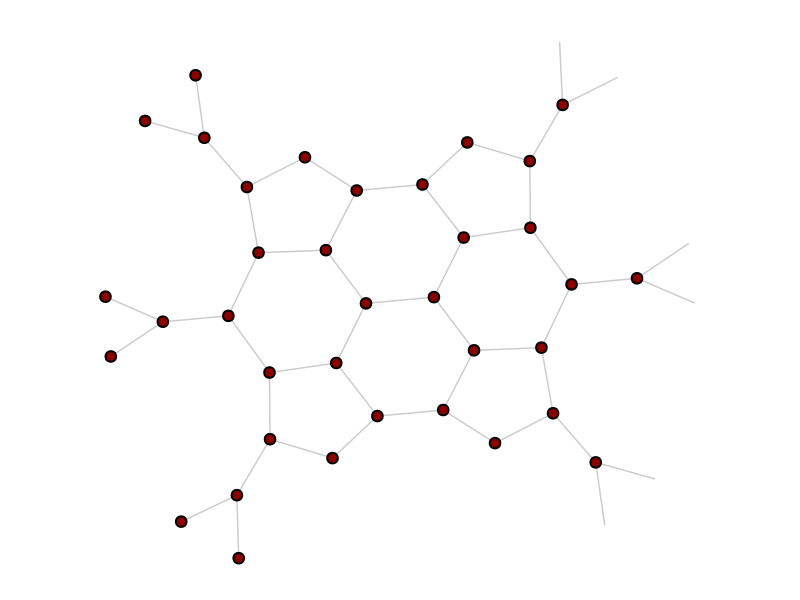

contracting initial network.....
index_cycle = [Symbol("15"), Symbol("16"), Symbol("c2150c02-e598-407e-a216-97a0408bdf40"), Symbol("10"), Symbol("9"), Symbol("7eec33ae-ff5d-4fe4-9ec3-1183124665ef")]
Created a group:
indices tensor 1[Symbol("9bfa2c6e-9d8c-4e48-94a3-b2c141507539"), Symbol("1000"), Symbol("1001")]with sizes[4, 2, 2]
indices identity_1:[Symbol("1000"), Symbol("1001"), Symbol("1002")]with sizes[2, 2, 4]
Created a split:
indices identity  1 inv[Symbol("1002"), Symbol("1003"), Symbol("1004")]with sizes[4, 2, 2]
indices tensor 2[Symbol("8"), Symbol("1003"), Symbol("1005")]with sizes[2, 2, 4]
Created a group:
indices identity 2[Symbol("1004"), Symbol("1005"), Symbol("1006")]with sizes[2, 4, 8]
Created a split:
indices identity  2 inv[Symbol("1006"), Symbol("1007"), Symbol("1008")]with sizes[8, 4, 2]
indices tensor 3[Symbol("1007"), Symbol("14"), Symbol("1009")]with sizes[4, 2, 2]
Created a group:
indices identity 3[Symbol("1008"), Symbol("1009"), Symbol("1010")]with sizes[2, 2,

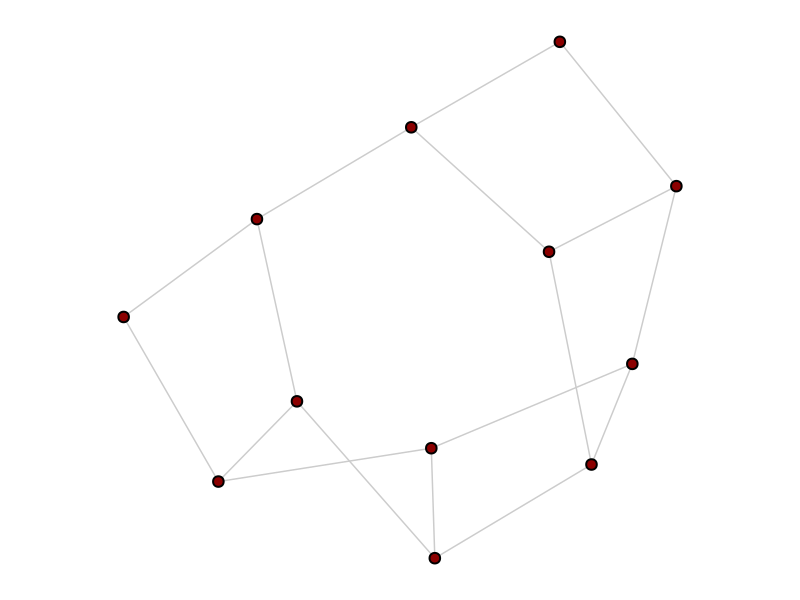

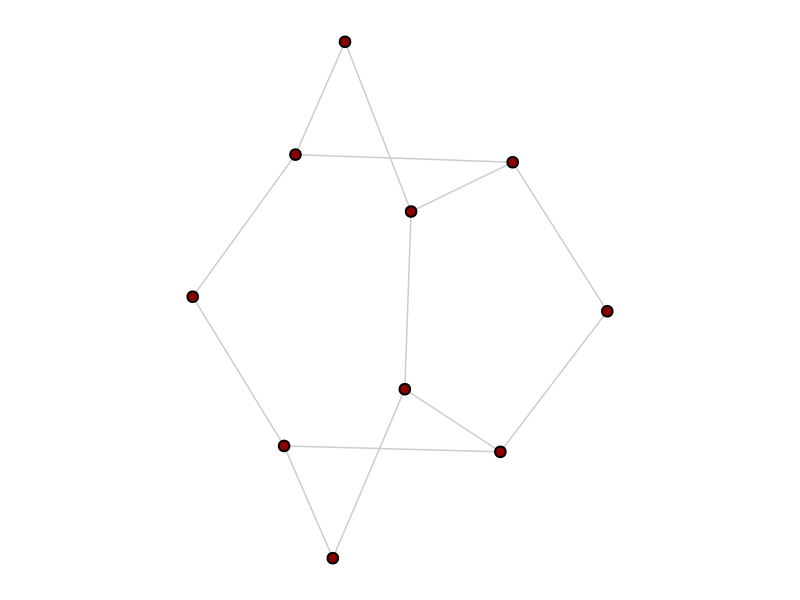

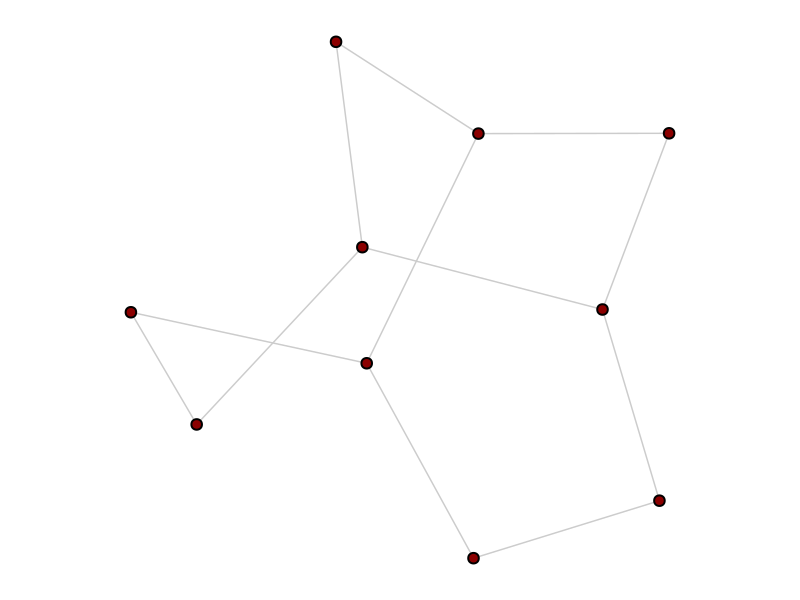

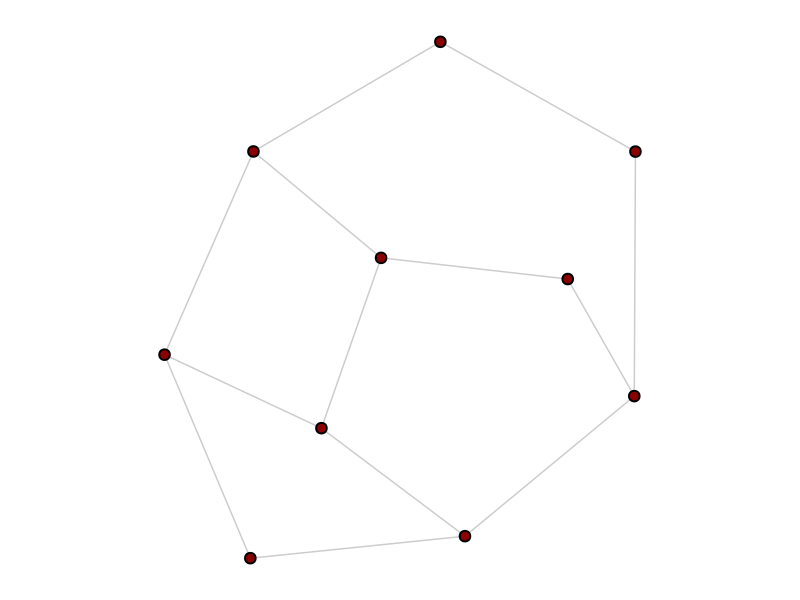

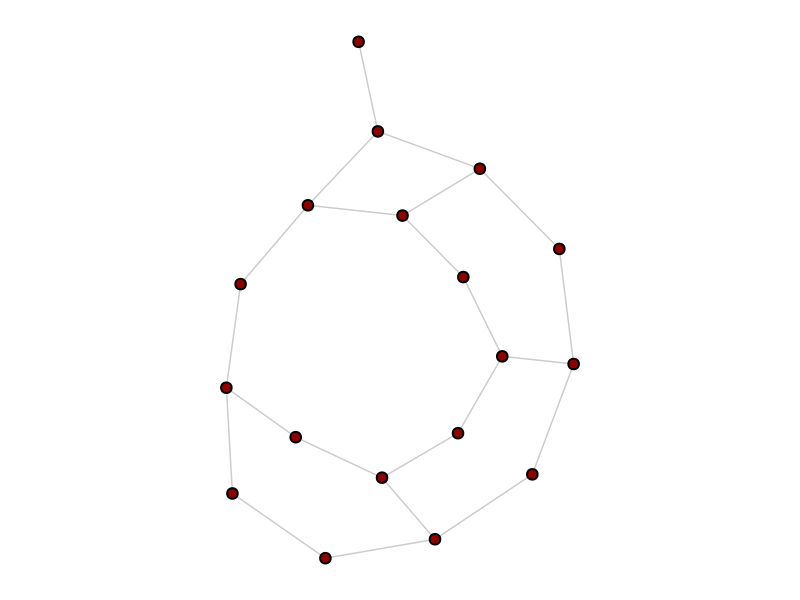

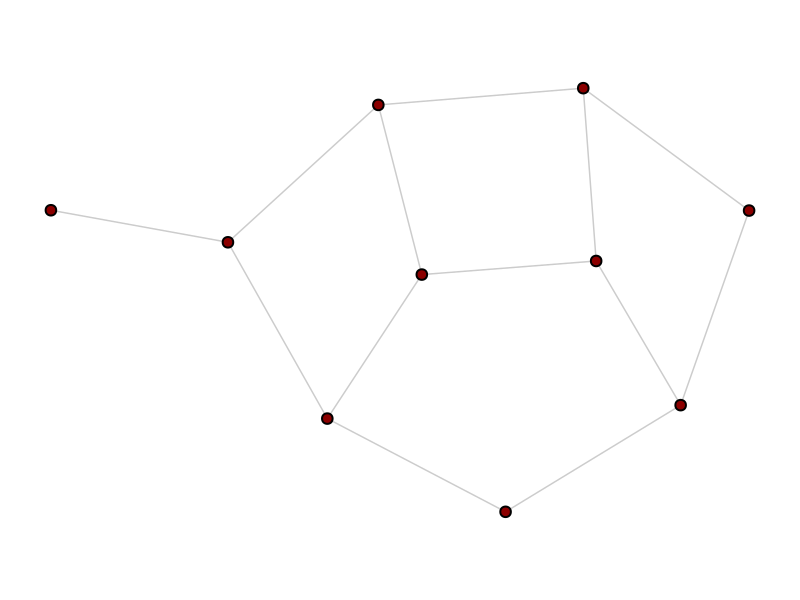

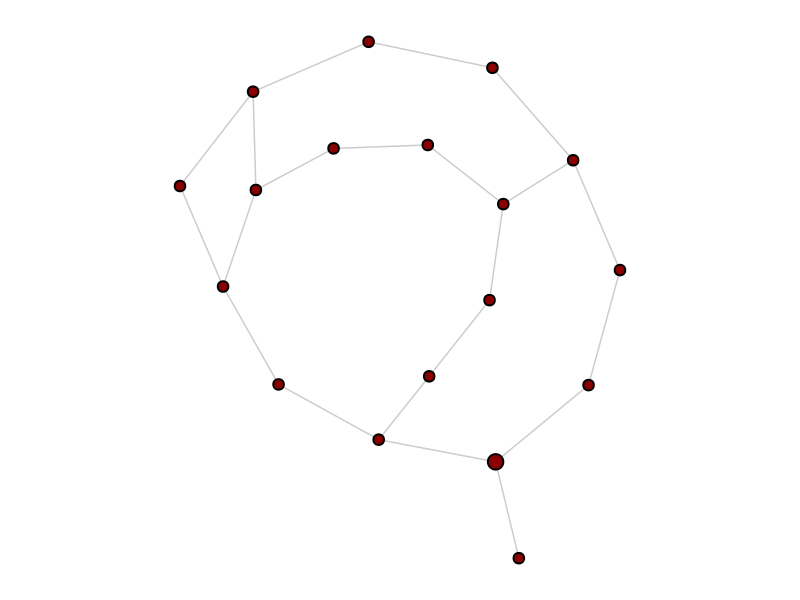

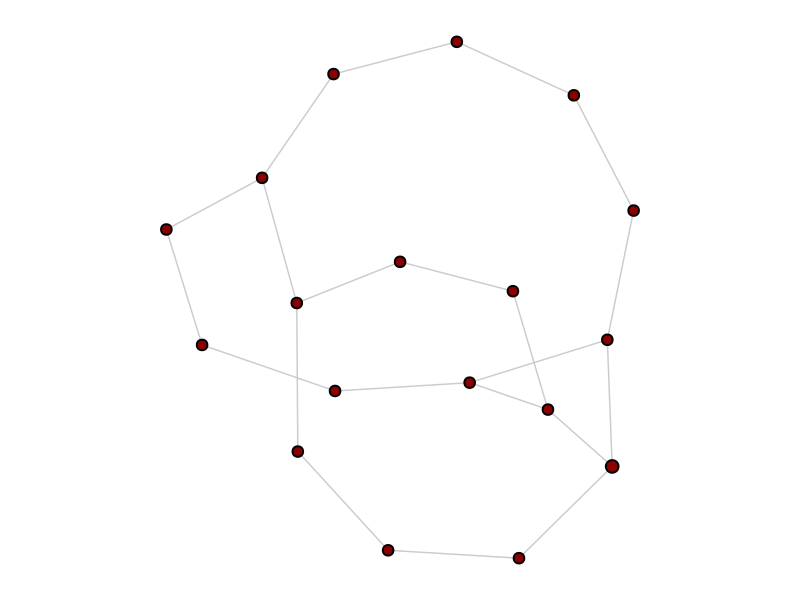

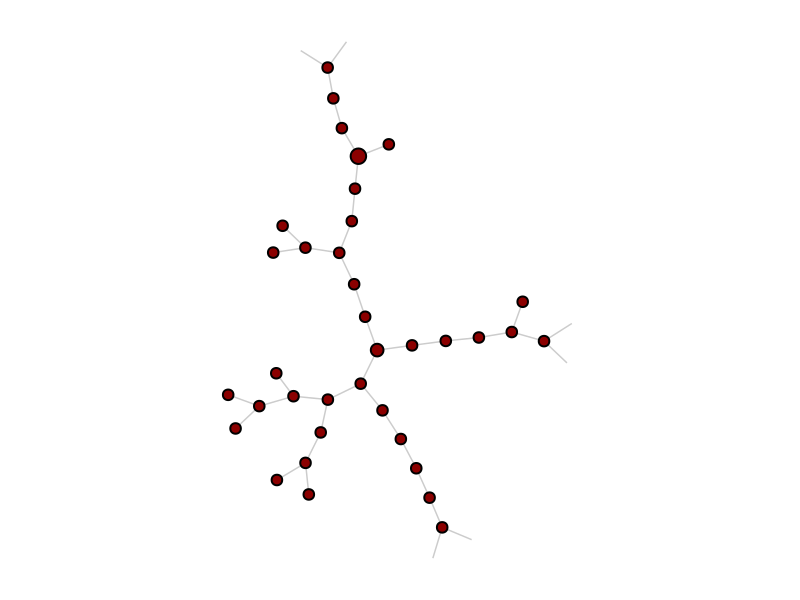

TensorNetwork(#tensors=36, #inds=41)

In [37]:
tree_i_fication(TN, taken_path)

